## Imports

In [1]:
## Activate venv python in powershell
## .\tcc\Scripts\activate.ps1


In [13]:
import wfdb
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from tqdm import tqdm
import math
from wfdb import processing
from numpy.linalg import norm
import cv2
from sklearn.cluster import KMeans,MeanShift
from sklearn.cluster import DBSCAN
import pandas as pd
from skimage import io, morphology
from scipy import signal

## Utils

In [34]:
def show_matrix(matrix,map='jet',show=True,return_img=False):
    '''
    Função para plotar uma matriz de valores.
    :param matrix: matriz de valores.
    :param map: cmap do matplotlib.
    :param show: se True, plota a imagem.
    :param return_img: se True, retorna a imagem.
    '''
    # Obtain the colormap
    colormap = plt.cm.get_cmap(map)
    # Normalize the intensity values
    norm = plt.Normalize(vmin=np.min(matrix), vmax=np.max(matrix))
    # Map intensity values to RGBA using the colormap
    rgb_image = colormap(norm(np.abs(matrix)))[:, :, :3]  # Discard the alpha channel
    if show:
        fig, ax = plt.subplots()
        ax.imshow(np.abs(matrix), cmap=map)
        plt.show()
    if return_img:
        return rgb_image

In [111]:
def float_to_unint(float_img):
    '''
    Função para converter uma imagem de float para uint8.
    :param float_img: imagem em float.
    :return uint8_image: imagem em uint8.
    '''
    # Clip values to the range [0, 1]
    clipped_image = np.clip(float_img, 0, 1)

    # Scale to the range [0, 255] and convert to uint8
    uint8_image = (clipped_image * 255).astype(np.uint8)
    return uint8_image

In [26]:
# Aplicar a operação de dilatação
def dilate_imag(img,iterations=10,kernel=(5,5),show = True):
    kernel = np.ones(kernel, np.uint8)
    dilation_result = cv2.dilate(img, kernel, iterations=iterations)

    if show:
        # Exibir as imagens original e resultante
        plt.subplot(121), plt.imshow(img,cmap='gray')
        plt.subplot(122), plt.imshow(dilation_result, cmap='gray'), plt.title('Com Dilatação')
        plt.show()
    else:
        return dilation_result
    
## Apply erosion on v image
def erode_img(img,iterations = 10,kernel=(5,5),show=True):
    kernel = np.ones(kernel, np.uint8)
    erosion_result = cv2.erode(img, kernel, iterations=iterations)

    if show:
        # Exibir as imagens original e resultante
        plt.subplot(121), plt.imshow(img,cmap='gray')
        plt.subplot(122), plt.imshow(erosion_result, cmap='gray'), plt.title('Com Erosão')
        plt.show()
    else:
        return erosion_result

def opening_img(img,iterations = 10,kernel=(5,5),show=True):
    kernel = np.ones(kernel, np.uint8)
    opening_result = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=iterations)

    if show:
        # Exibir as imagens original e resultante
        plt.subplot(121), plt.imshow(img,cmap='gray')
        plt.subplot(122), plt.imshow(opening_result, cmap='gray'), plt.title('Com Opening')
        plt.show()
    else:
        return opening_result
    
def closing_img(img,iterations = 10,kernel=(5,5),show=True):
    kernel = np.ones(kernel, np.uint8)
    closing_result = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    if show:
        # Exibir as imagens original e resultante
        plt.subplot(121), plt.imshow(img,cmap='gray')
        plt.subplot(122), plt.imshow(closing_result, cmap='gray'), plt.title('Com Closing')
        plt.show()
    else:
        return closing_result

## Data

In [112]:
class ECG_distance_matrix:
    def __init__(self, patient, record):
        self.patient = patient
        self.record = record
    
    def get_signal(self):
        '''
        Read the signal
        :return sign: signal
        :return fields: fields
        '''
        ## Read the signal
        sign, fields = wfdb.rdsamp(f'data/ptb-diagnostic-ecg-database-1.0.0/{self.patient}/{self.record}', channels=[*range(15)])
        return sign, fields
    
    def plot_12d_signal(self, sign,start=0, end=2000):
        '''
        Plot 12d signal
        :param sign: signal to plot
        :param start: start index
        :param end: end index
        '''
        # Extract the first 1500 samples from the first 12 channels
        sig = sign[:, :12][start:end]
        # Create a new figure with a larger size
        plt.figure(figsize=(12, 20))
        # Plot each signal channel in a different subplot with some style
        for i in range(12):
            ax = plt.subplot(12, 1, i + 1)
            # Plot the signal
            plt.plot(sig[:, i], label=f'Channel {i+1}', linewidth=1)
            # Add some style
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.legend()
            # Remove x-axis ticks for all but the last subplot
            if i < 11:
                plt.xticks([])
            # Add y-axis label for the middle subplot
            if i == 5:
                plt.ylabel('Amplitude')
            # Add a title for the entire plot
            if i == 0:
                plt.title('Signal Channels')
        # Adjust layout for better spacing
        plt.tight_layout()
        # Show the plot
        plt.show()

    def filt_bandpass(self,sig,fs,fh=50,fl=1,ordem=3):
        '''
        Filtro Butterworth passa banda, ordem 3. Frequência de corte 1hz e 50hz.
        :param sig: sinal a ser filtrado
        :param fs: frequência de amostragem do sinal.
        :param fh: frequência de corte superior.
        :param fl: frequência de corte inferior.
        :param ordem: ordem do filtro.
        :return sig_filt: sinal filtrado.
        '''
        nyq = 0.5*fs # frequência de Nyquist
        high = fh/nyq
        low = fl/nyq
        b, a = signal.butter(ordem, [low, high], btype='band')
        sig_filt = signal.filtfilt(b, a, sig, axis = 0)
            
        return sig_filt
    
    def generate_image(self,signal):
        '''
        Função para gerar a matriz de distância a partir de um sinal utilizando a distância euclidiana.
        :param signal: sinal a ser utilizado.
        '''
        diffs = signal[:, np.newaxis, :] - signal[np.newaxis, :, :]
        dists = norm(diffs, axis=2)
        l = np.concatenate((l, dists), axis=0) if 'l' in locals() else dists
        return l
    
    def get_distance_matrix(self,sign,start,end):    
        '''
        Função para gerar a matriz de distância a partir de um sinal.
        :param sign: sinal a ser utilizado.
        :param start: início do sinal.
        :param end: fim do sinal.
        :return matrix_dist: matriz de distância.
        '''          
        sign = sign[:, :12]
        self.filt_sign = self.filt_bandpass(sign,1000)
        sig = self.filt_sign[start:end]
        matrix_dist = self.generate_image(sig)
        return matrix_dist


In [58]:
## Getting path image
path_img = 'Base\\Myocardial infarction\\patient003_s0017lre_12d_Myocardialinfarction_anterior_886-5886.png'
## Extracting infos from path
infos_path = path_img.split('\\')[2].split('_')
patient, record, start, end = infos_path[0], infos_path[1], int(infos_path[-1].replace(".png", "").split('-')[0]), int(infos_path[-1].replace(".png", "").split('-')[1])
## OR
patient, record, start, end = 'patient112', 's0169_re', 22524, 24524

In [113]:
## Creating object
pat112 = ECG_distance_matrix(patient, record)
pat112_sign, _ = pat112.get_signal()
#pat112.plot_12d_signal(pat112_sign)
sign = pat112_sign[:, :12]
filt_sign = pat112.filt_bandpass(sign,1000)
sig = filt_sign[start:end]
matrix_dist = pat112.generate_image(sig)
matrix_img = show_matrix(matrix_dist,return_img=True,show=False)

## OR for other patients
'''
pat112 = ECG_distance_matrix(patient, record)
pat112_sign, _ = pat112.get_signal()
matrix_dist = pat112.get_distance_matrix(pat112_sign,start,end)
'''

'\npat112 = ECG_distance_matrix(patient, record)\npat112_sign, _ = pat112.get_signal()\nmatrix_dist = pat112.get_distance_matrix(pat112_sign,start,end)\n'

## Remoção de linha de Base

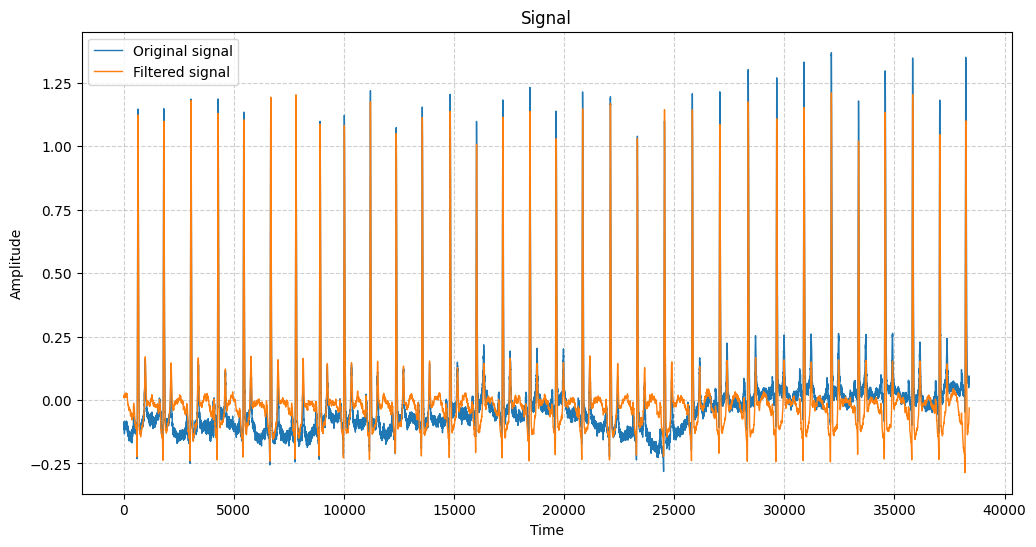

In [61]:
# Plot signal before and after filtering
plt.figure(figsize=(12, 6))
plt.plot(sign[:, 0], label='Original signal', linewidth=1)
plt.plot(filt_sign[:, 0], label='Filtered signal', linewidth=1)
plt.legend()
plt.title('Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


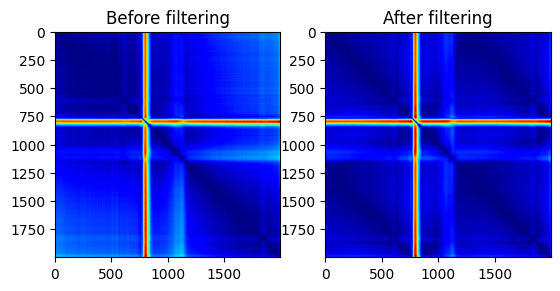

In [62]:
matrix_img_bef = show_matrix(pat112.generate_image(sign[start:end]),return_img=True,show=False)
## Show matrix_img and matrix_img_bef in subplots
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(matrix_img_bef)
ax2.imshow(matrix_img)
ax1.title.set_text('Before filtering')
ax2.title.set_text('After filtering')
plt.show()

### Distância R-R

Text(0.5, 1.0, 'Histogram')

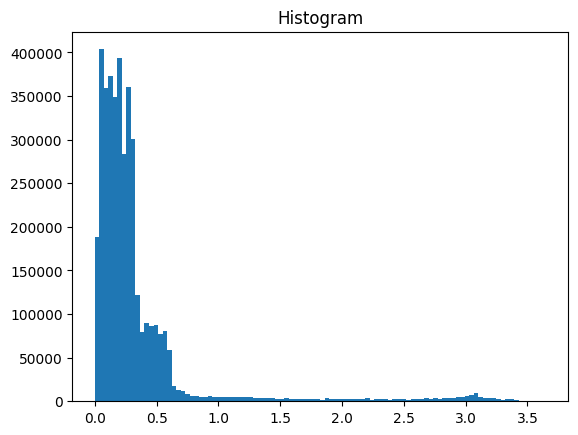

In [63]:
## Plot histogram from matrix_dist
plt.hist(matrix_dist.flatten(), bins=100)
plt.title('Histogram')

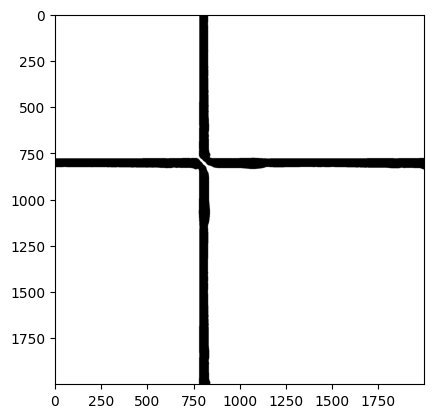

In [47]:
## Get quantiles from matrix
quantiles = np.quantile(matrix_dist, [0.25, 0.5, 0.95])
## Applying a threshold to the matrix on 0.95 quantile
matrix_dist_t = (matrix_dist < quantiles[2])*255
show_matrix(matrix_dist_t,map="gray")

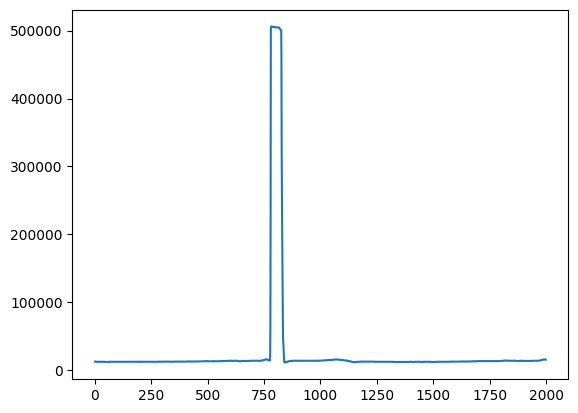

In [48]:
## Plotting the sum of the matrix columns
matrix_dist_bin = 255 - matrix_dist_t
sums = []
for i in range(matrix_dist_bin.shape[0]):
    sums.append(sum(matrix_dist_bin[:, i]))
plt.plot(sums)
plt.show()

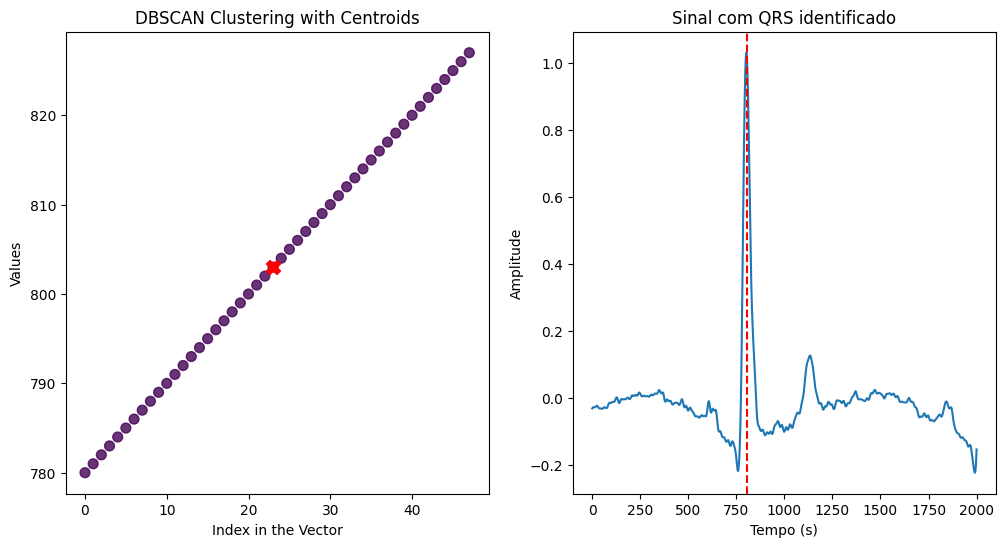

In [49]:
## Identifying peaks from the sum of the matrix columns
peaks = []
first_last = {}
limiar = max(sums)*0.75
for i in range(matrix_dist_bin.shape[0]):
    if sum(matrix_dist_bin[:, i]) > limiar:
        peaks.append(i)
        
# Data vector
data = np.array(peaks)

# Reshape the vector to be a two-dimensional matrix
data_reshaped = data.reshape(-1, 1)

# Apply DBSCAN
dbscan = DBSCAN(eps=100, min_samples=2)
labels = dbscan.fit_predict(data_reshaped)

# Find the mean for each cluster
unique_labels = np.unique(labels)
centroids = []

for label in unique_labels:
    if label == -1:  # Skip noise points
        continue
    cluster_points = data[labels == label]
    cluster_mean = np.mean(cluster_points)
    centroids.append(cluster_mean)
    first_last[label] = [min(cluster_points), max(cluster_points)]


idxs = []
for k in centroids:
    idxs.append(np.where(data == int(k))[0][0])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 6))

# Plot the results with centroids
ax1.scatter(range(len(data)), data, c=labels, cmap='viridis', s=50, alpha=0.8)
ax1.scatter(idxs, [data[i] for i in idxs], marker='X', color='red', s=100)
ax1.set_title('DBSCAN Clustering with Centroids')
ax1.set_xlabel('Index in the Vector')
ax1.set_ylabel('Values')

## Plot centroids with a line on signal
t = np.linspace(0, len(sig), len(sig))
ax2.plot(t, sig[:,0], label='Sinal original')
for i in centroids:
    ax2.axvline(x=i, color='r', linestyle='--')
ax2.set_title('Sinal com QRS identificado')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Amplitude')
plt.show()

In [50]:
## Calculating R-R interval and heart rate
rr = []
hr = []
fs = 1000
for i in range(len(centroids)-1):
    diff = (centroids[i+1] - centroids[i])/fs
    rr.append(diff)
    hr.append(60/diff)
print(rr)
print(hr)

[]
[]


In [71]:
len_min = 0 
channel_i = 0
ind = False
for channel in range(0,12):
    qrs_inds_min = processing.xqrs_detect(sig=filt_sign[:,channel], fs=1000,verbose=False)
    if len(qrs_inds) > len_min:
        qrs_inds = qrs_inds_min
        channel_i = channel
        ind = True
        #break

## Plot signal and each point from qrs_inds
if ind == True:
    plt.figure(figsize=(12, 6))
    plt.plot(filt_sign[:, channel_i], label='Signal', linewidth=1)
    plt.scatter(qrs_inds, filt_sign[qrs_inds, channel_i], label='R-peaks', color='red')
    plt.legend()
else:
    print('No peaks found from wqrs_detect')

No peaks found from wqrs_detect


### T Wave

#### Clusterization

In [74]:
def cluster_image_kmeans(image, n_clusters=4):
    # Reshape the image to a 2D array of pixels (rows, columns, channels)
    pixels = image.reshape((-1, 3))  # Assuming it's a 3-channel (RGB) image

    # Choose the number of clusters (k)
    k = n_clusters

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(pixels)

    # Reshape the labels to the original image shape
    labels_reshaped = labels.reshape(image.shape[:2])

    # Assign unique colors to each cluster label
    unique_labels = np.unique(labels_reshaped)
    num_clusters = len(unique_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))[:, :3]  # Use viridis colormap

    # Create a colored image based on cluster labels
    colored_image = colors[labels_reshaped]

    # Display the original and clustered images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image,cmap='jet')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(labels_reshaped, cmap='viridis')
    plt.title('Cluster Labels')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(colored_image)
    plt.title('Clustered Image')
    plt.axis('off')

    plt.show()

    return labels_reshaped

In [108]:
'''## New object
patient = 'patient043'
record = 's0141lre'
pat043 = ECG_distance_matrix(patient, record)
pat043_sign, _ = pat043.get_signal()
matrix_dist_043 = pat043.get_distance_matrix(pat043_sign,start,end)
matrix_img_043 = show_matrix(matrix_dist_043,return_img=True,show=False)
matrix_unint43 = float_to_unint(matrix_img_043)''''''


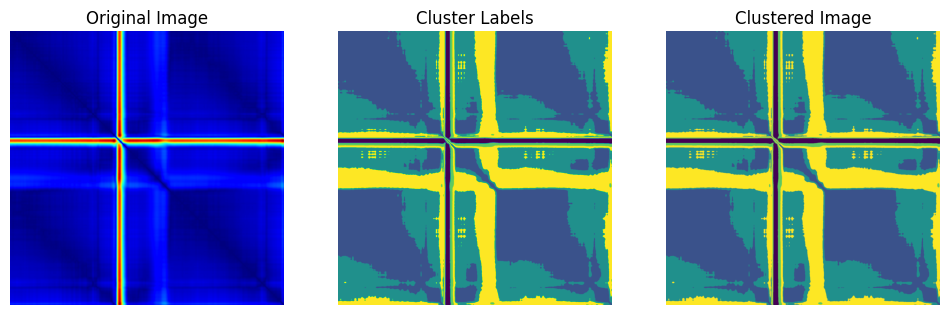

In [105]:
matrix_unint = float_to_unint(matrix_img)
n_clusters = 5
labels_reshaped = cluster_image_kmeans(matrix_unint, n_clusters=n_clusters)

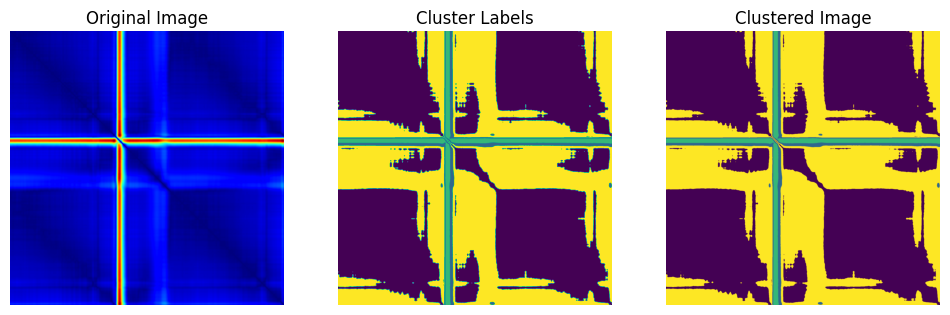

In [77]:
n_clusters = 4
labels_reshaped = cluster_image_kmeans(matrix_unint, n_clusters=n_clusters)

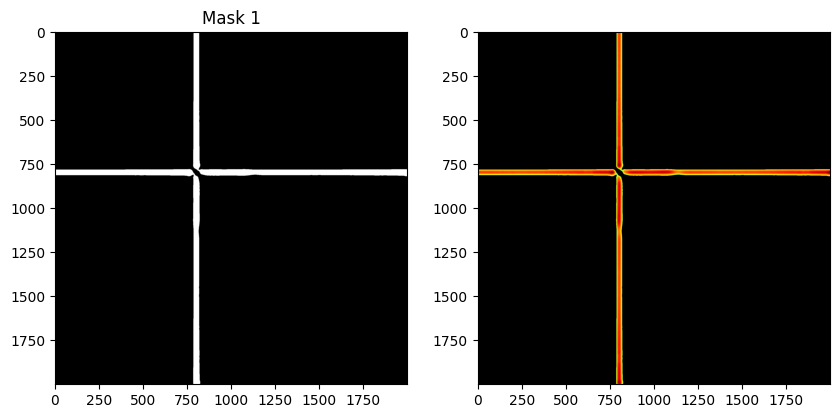

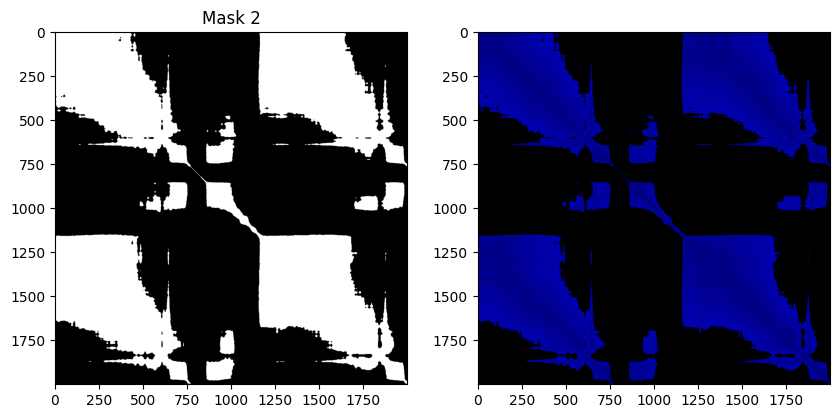

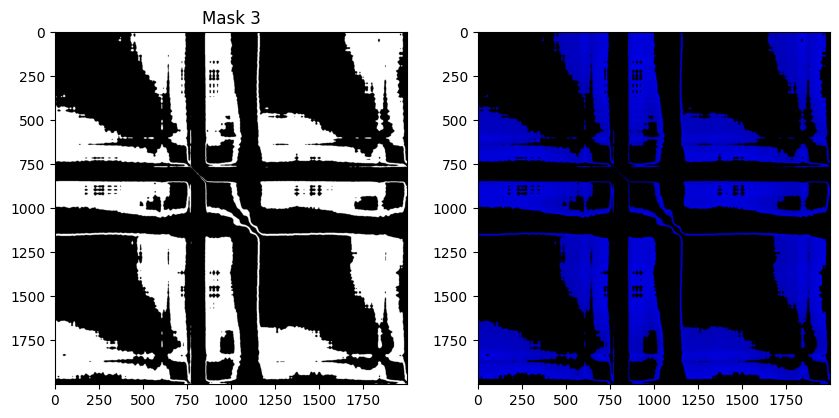

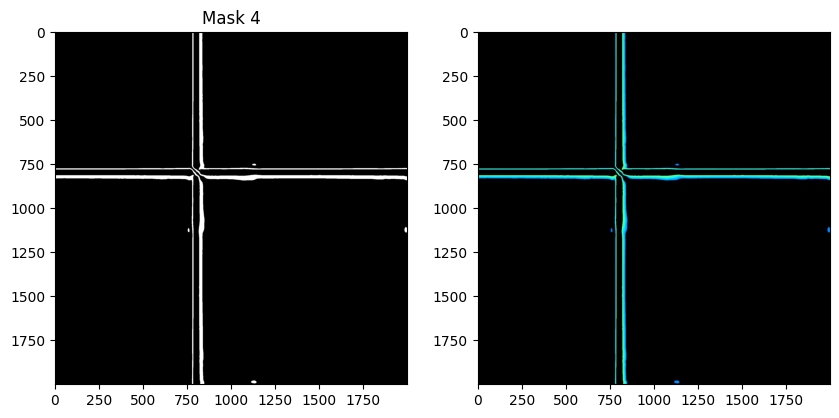

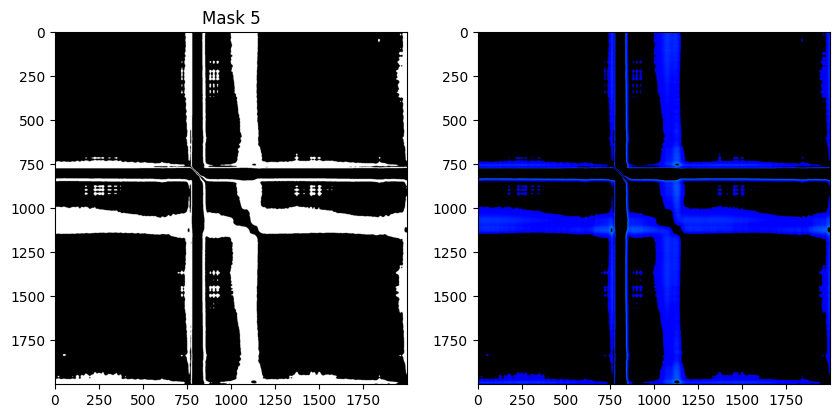

In [106]:
## Show each cluster separately
masks = []
masks_img = []
image = matrix_unint
for i in range(n_clusters):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    label_choose = i
    mask = (labels_reshaped == label_choose)
    mask_img = show_matrix(mask*255,map = 'gray',show=False,return_img=True)
    masks.append(mask_img)
    ## Apply mask on original image
    masked_image = image.copy()
    masked_image[~mask] = 0
    masks_img.append(masked_image)
    ax[0].imshow(mask_img)
    ax[1].imshow(masked_image)
    ax[0].title.set_text(f'Mask {label_choose+1}')
    plt.show()

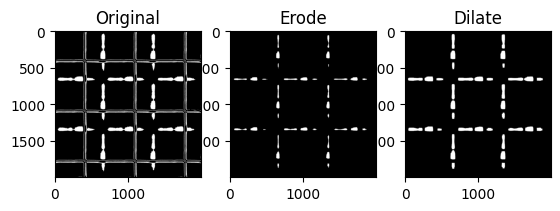

In [96]:
t_wave = masks[4]
## Apply erosion on t_wave
t_wave_erode = erode_img(t_wave,iterations=5,kernel=(5,5),show=False)
t_wave_dilate = dilate_imag(t_wave_erode,iterations=5,kernel=(5,5),show=False)
## Show t_wave_erode and t_wave_dilate in subplots
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(t_wave)
ax2.imshow(t_wave_erode)
ax3.imshow(t_wave_dilate)
ax1.title.set_text('Original')
ax2.title.set_text('Erode')
ax3.title.set_text('Dilate')
plt.show()

Vai ser preciso desenvolver um método para identificar a máscara correspondente que melhor destaca a onda T

150.73921252169677


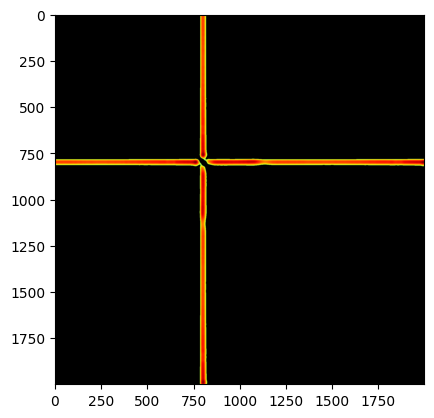

17.715871073136213


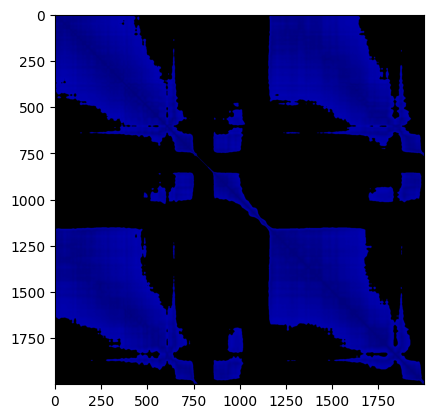

23.1623085788424


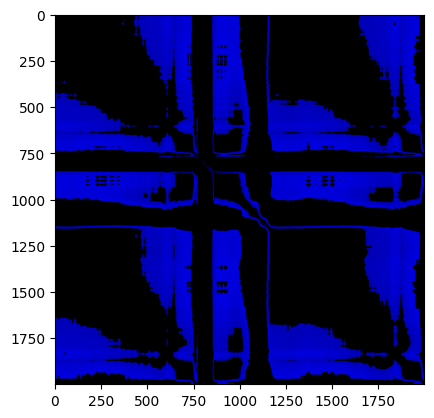

161.5056899810964


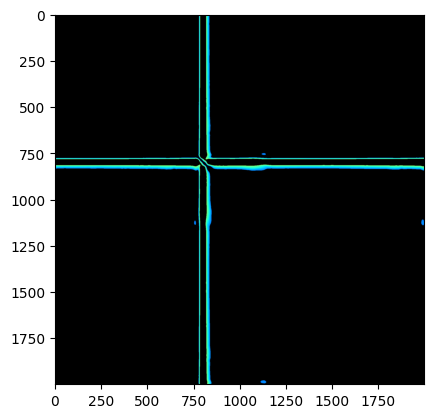

37.7625309307785


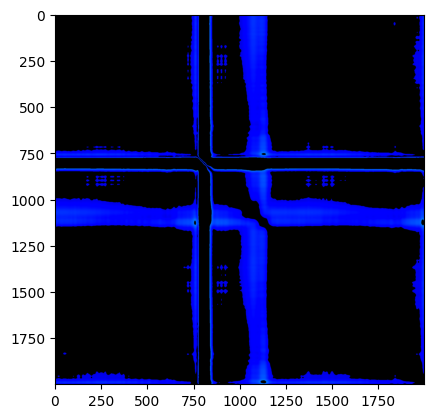

In [107]:
## Tentando identificar pelo brilho
# Converter para escala de cinza
for m in masks_img:
    gray_image = cv2.cvtColor(m, cv2.COLOR_RGB2GRAY)
    # Criar uma máscara para os pixels pretos (assumindo que preto é 0)
    black_mask = gray_image > 0

    # Calcular a média da intensidade de cor (brilho) excluindo os pixels pretos
    brightness = np.mean(gray_image[black_mask])

    plt.imshow(m)
    print(brightness)
    plt.show()


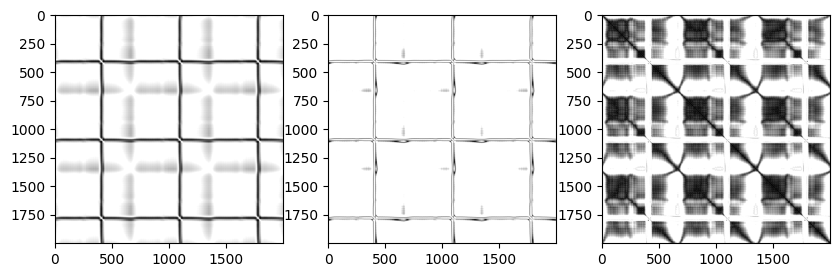

In [114]:
image = float_to_unint(show_matrix(matrix_dist,return_img=True,show=False))
## Image to HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
## Plot each channel
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
h = hsv_image[:,:,0]
s = hsv_image[:,:,1]
v = hsv_image[:,:,2]
ax[0].imshow(h, cmap='gray')
ax[1].imshow(s, cmap='gray')
ax[2].imshow(v, cmap='gray')

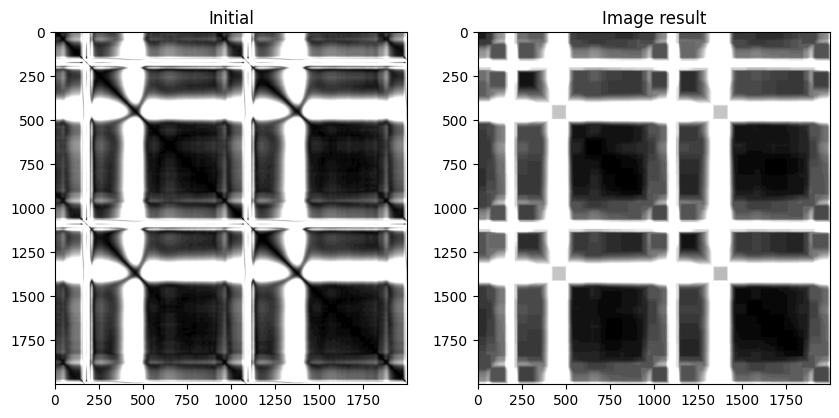

In [112]:
## Eroding image
img_dilate = dilate_imag(v,iterations=10,kernel=(5,5),show=False)
img_open = opening_img(img_dilate,iterations=10,kernel=(5,5),show=False)
img_erode = erode_img(img_open,iterations=10,kernel=(5,5),show=False)
img_close = closing_img(img_erode,iterations=10,kernel=(8,8),show=False)

## Plotting v and image close
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(v, cmap='gray')
ax[1].imshow(img_close, cmap='gray')
ax[0].title.set_text('Initial')
ax[1].title.set_text('Image result')
plt.show()

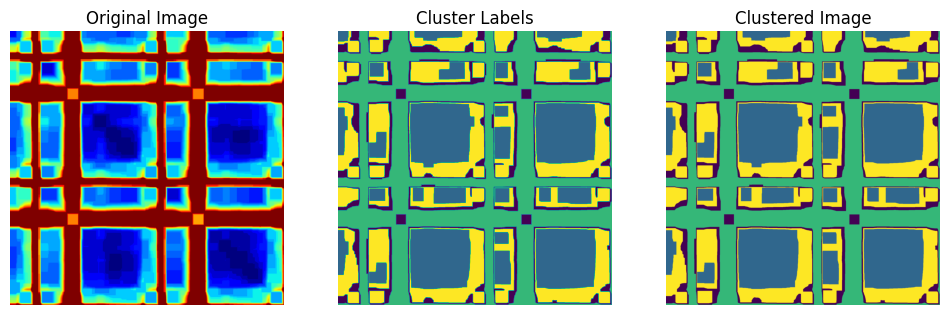

In [113]:
n_clusters = 4
labels_reshaped = cluster_image_kmeans(img_close, n_clusters=n_clusters)

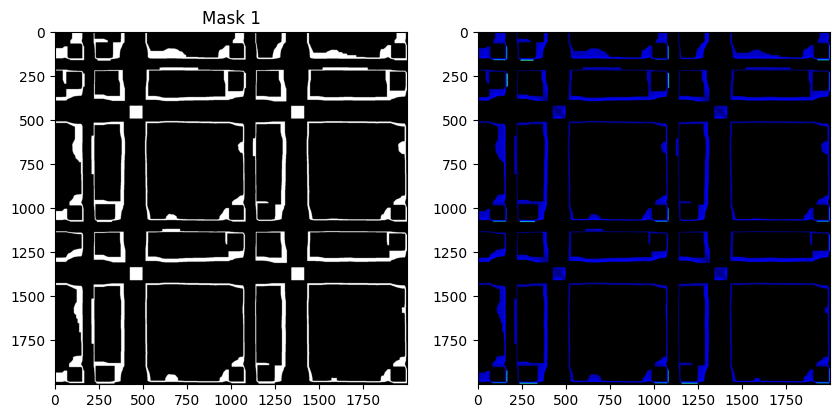

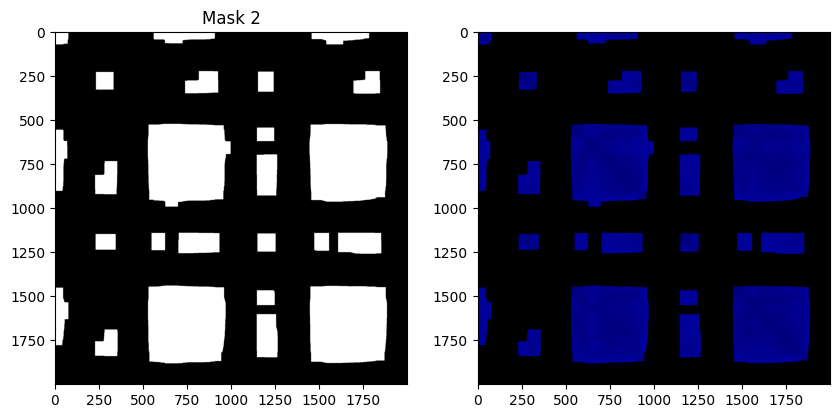

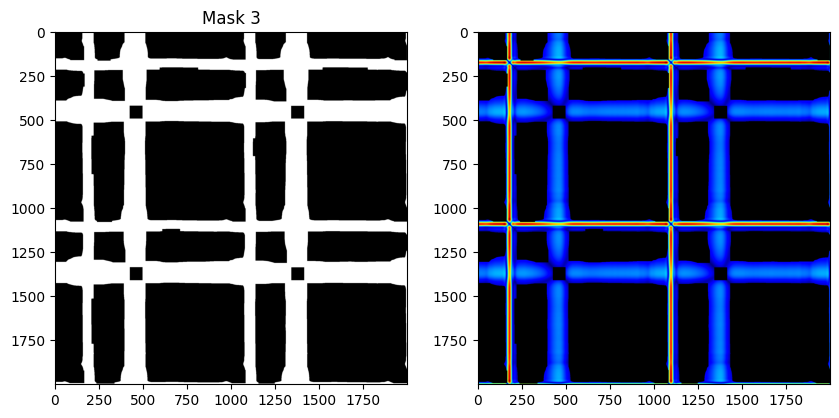

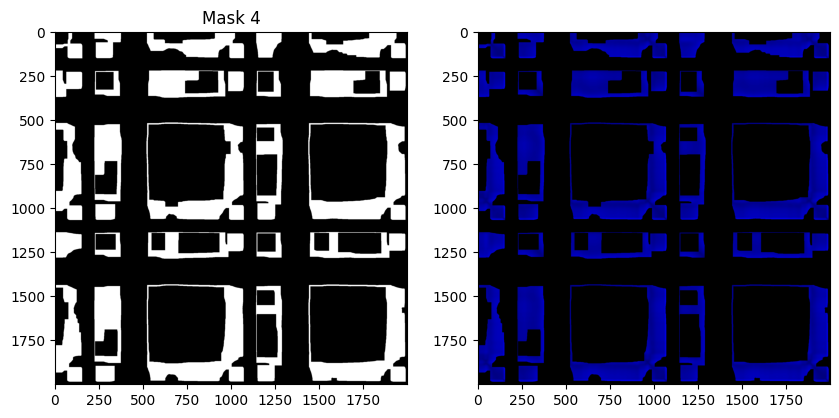

In [114]:
## Show each cluster separately
for i in range(n_clusters):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    label_choose = i
    mask = (labels_reshaped == label_choose)
    mask_img = show_matrix(mask*255,map = 'gray',show=False,return_img=True)
    ## Apply mask on original image
    masked_image = image.copy()
    masked_image[~mask] = 0
    ax[0].imshow(mask_img)
    ax[1].imshow(masked_image)
    ax[0].title.set_text(f'Mask {label_choose+1}')
    plt.show()

## Others tools

#### Correlation

In [115]:
import scipy.stats
patient = "patient123"
record = "s0224_re"
pat123 = ECG_distance_matrix(patient, record)
sign_123, _ = pat123.get_signal()
sign_c = sign_123[:, :12]
## Filtering signal
filt_sign_c = pat123.filt_bandpass(sign_c,1000)
sig_c = filt_sign_c[28822:30822]
matrix_dist_c = pat123.generate_image(sig_c)
col1 = matrix_dist_c[:,10]
all_values = []
for i in range(2000):
    col2 = matrix_dist_c[:,i]
    correlation_coef, p_value = scipy.stats.pearsonr(col1, col2)
    spearman_coef, p_value_spearman = scipy.stats.spearmanr(col1, col2)
    if correlation_coef > 0.95 and spearman_coef > 0.95:
        all_values.append(i)

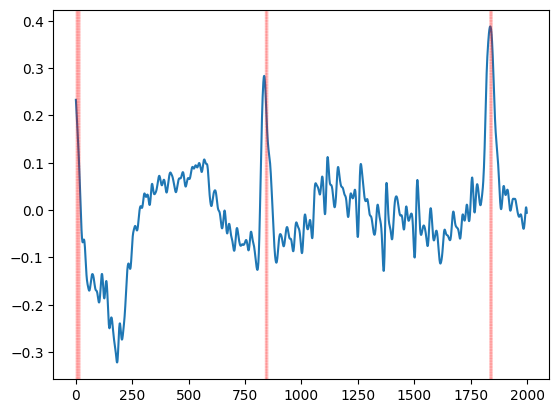

In [116]:
## Plot on signal all this points
plt.plot(sig_c[:,0])
for i in all_values:
    plt.axvline(x=i, color='r', linestyle='--',linewidth=0.1)
plt.show()